### Experiment CNN on trap camera photos

The dataset gathered is a collection of 25 000 images from missouri wild life camera. The dataset can be found at: https://lila.science/datasets/missouricameratraps

In [5]:
from opFunctions import setupDataset
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from helperFunctions import displayRandomImages

#### Setup the Test Data

In [6]:
targDir = "dataset/Set"

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor() 
])

lossFunction = nn.CrossEntropyLoss()

testData = setupDataset(targDir= targDir,
                        mode= "test",
                        transform=transform)

testDataLoader = DataLoader(dataset=testData,
                            batch_size=32,
                            shuffle=True)

In [7]:
classNames = testData.classes

### Show batch of the images

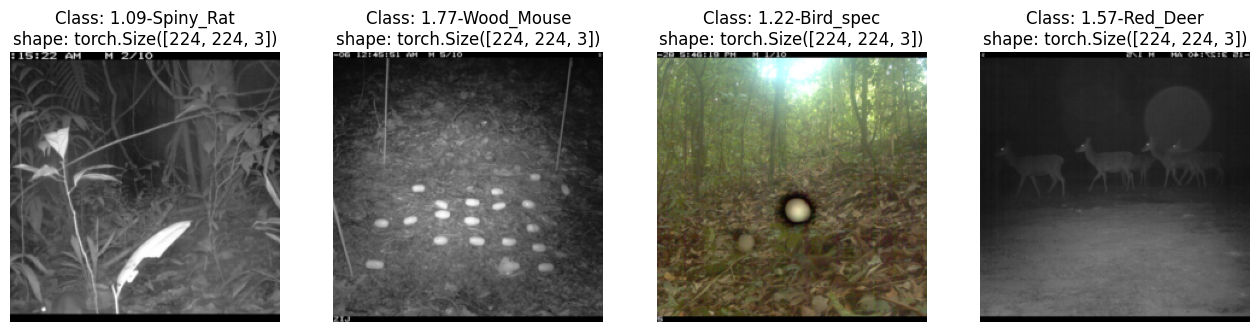

In [8]:
displayRandomImages(testData, classNames, 4)

### Model Specs 

In [9]:
from models import TinyVGGModel 
from torchinfo import summary

In [17]:
iteration1Model = TinyVGGModel(inputLayer=3,
                               hiddenLayer=16,
                               outputLayer=len(classNames))

In [18]:
modelDir = "modelsPT/ModITER3.pt"
iteration1Model.load_state_dict(torch.load(modelDir))

<All keys matched successfully>

In [19]:
iteration1Model

TinyVGGModel(
  (ConvLayer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classiferLayer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=44944, out_features=20, bias=True)
  )
)

### Test the model

In [21]:
from opFunctions import testStep 
testLoss, testAcc = testStep(iteration1Model, testDataLoader, lossFunction)
print(f"Test Loss: {testLoss:.4f} | Test Accuracy: {testAcc:.2f} %")

Test Loss: 5.0726 | Test Accuracy: 48.08 %


In [22]:
from helperFunctions import plotLossAndAccuracy

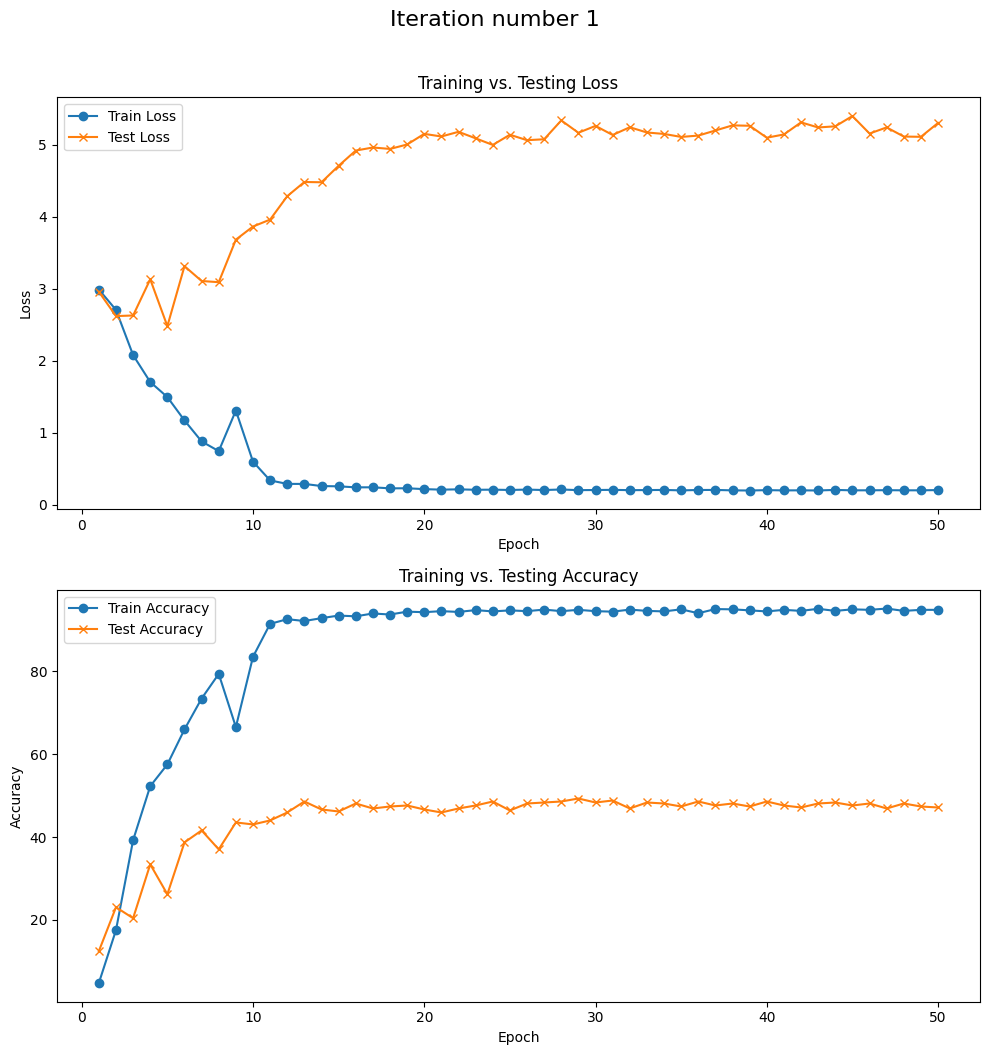

In [23]:
resultPath = "results/TrainingResults3.csv"
plotLossAndAccuracy(resultPath, 1)

#### NOTES 

We can see that with a decaying learning rate of step size 10 with a gamma of 0.1 the model tops out at around 95% accuracy on the training data. similarly the loss goes down in similar fashion. However, it's clear that there are overfitting in the model. Finding pattern specifically to the training images, but not generalizable for the entire set. 

Let's take a look at our data once more, to see what's might be occuring

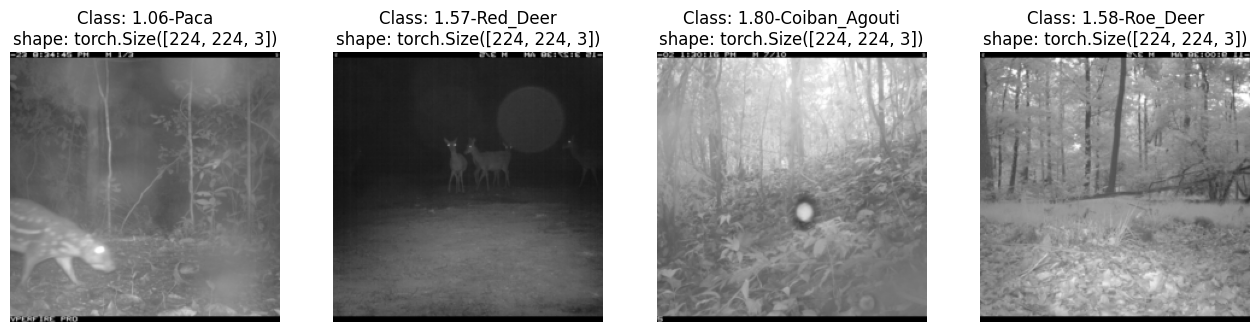

In [24]:
displayRandomImages(dataset= testData,
                    classes=classNames,
                    n=4)

##### Let's look at some training examples aswell

In [25]:
trainData = setupDataset(targDir=targDir,
                         mode="train",
                         transform=transform)

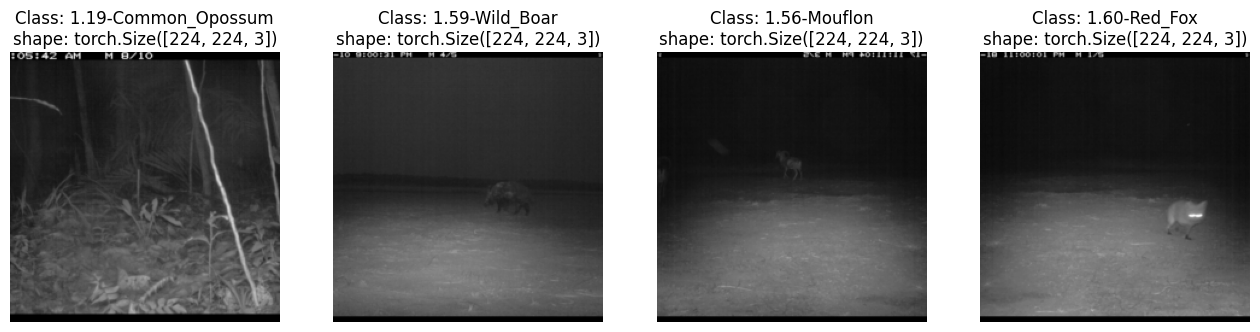

In [28]:
displayRandomImages(dataset= trainData,
                    classes=classNames,
                    n=4)

Alot of greyscale night photos. Not much that differentiates the photos. Think it would be hard to distinguish for our model

To improve it, let's do some adjustments to the model. 

* The model currently just have 2 hidden layers and 1 classification layer, Let's allow it to differentiate the pictures more in hyperspace, by adding more nodes (neurons) in each layer from 16 to 32.

* Let's also do some more data agmentation to the pictures to make the model's training more generalizable. 

* As shown in Norouzzadeh et al. (2021)[1], where triplet loss saw improved performance from Cross Entropy Loss, in camera trap images. We will therefore also implement triplets loss instead. 

[1] (https://besjournals.onlinelibrary.wiley.com/doi/pdfdirect/10.1111/2041-210X.13504) 

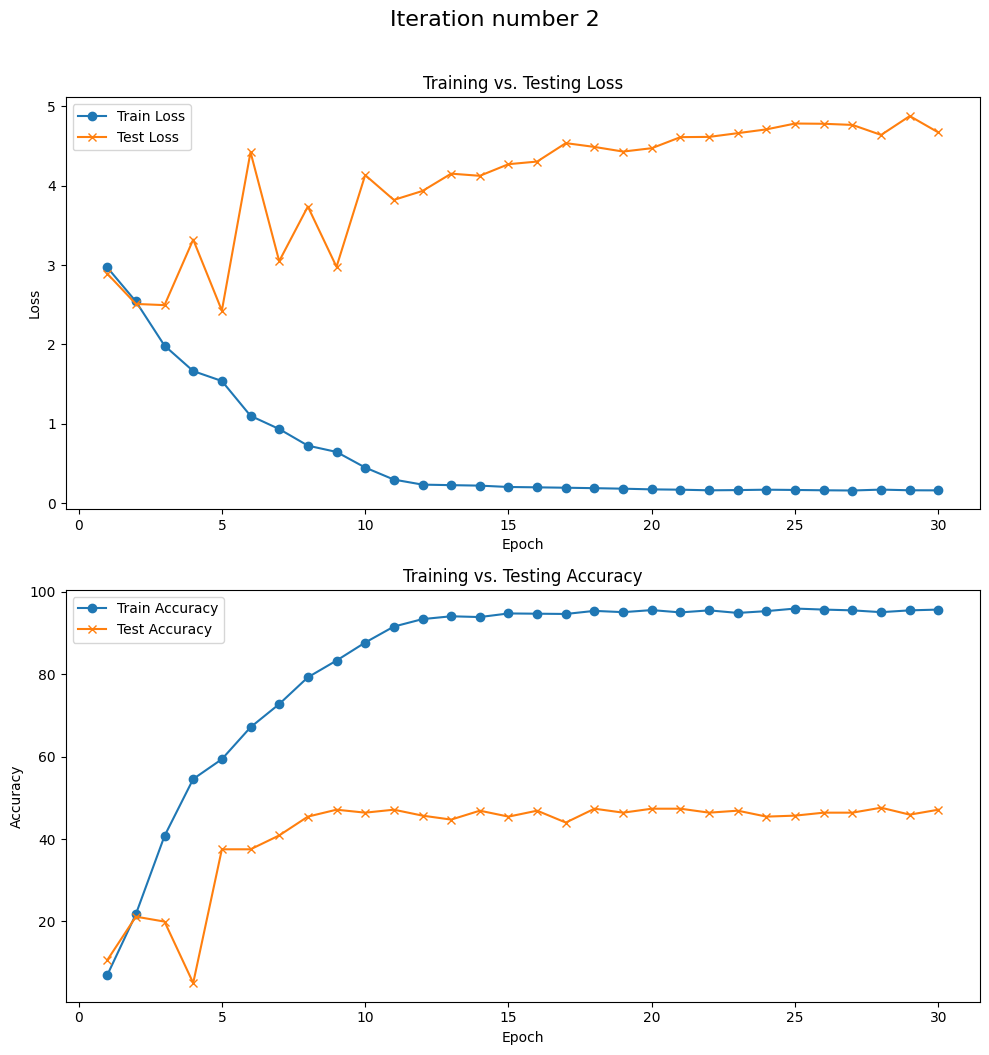

In [31]:
iteration2ModelResults = "results/TrainingResults2.csv"

plotLossAndAccuracy(iteration2ModelResults, 2)

After making the layers bigger, there doesnt seem to be that much of a difference. Let's try to augment the images more, so that the model generalizes pattern dispite the quality.

In [34]:
transformVersion2 = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor() 
])

In [35]:
trainDataTransformed = setupDataset(targDir=targDir,
                                    mode="train",
                                    transform=transformVersion2)

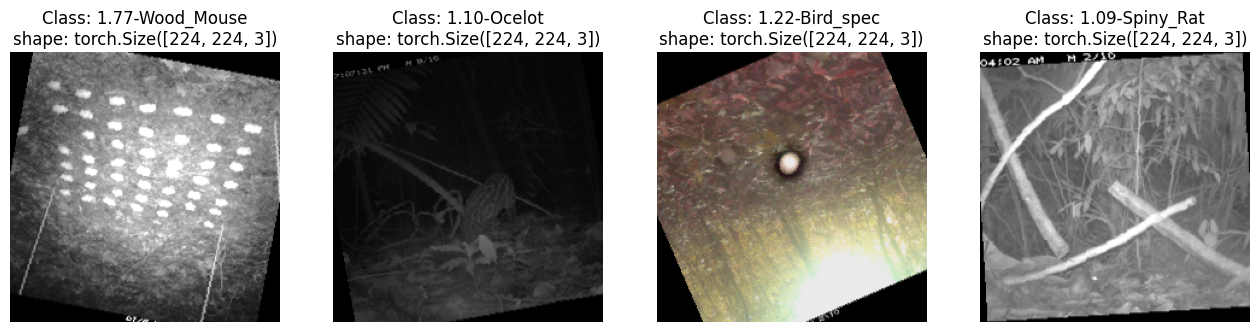

In [39]:
displayRandomImages(trainDataTransformed, classNames, 4)

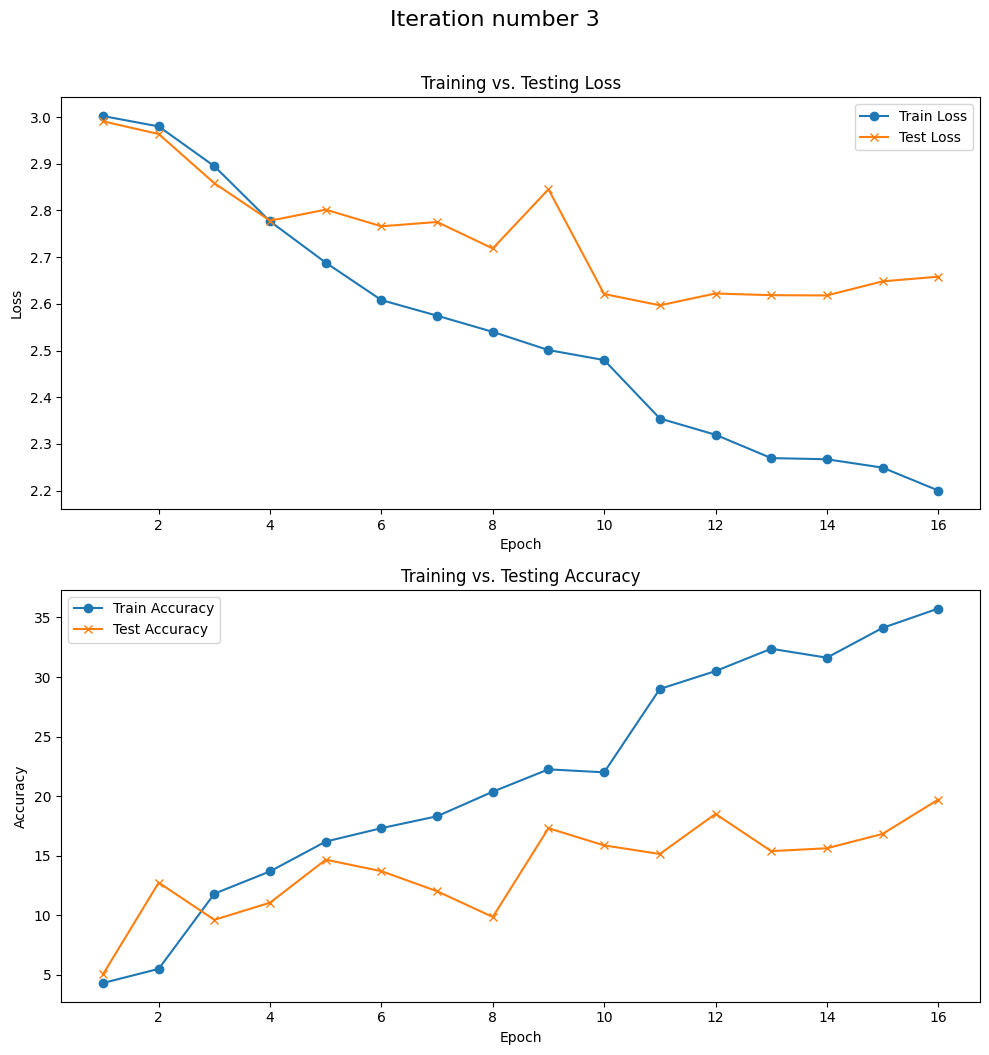

In [40]:
iteration3ModelResults = "results/TrainingResults3.csv"

plotLossAndAccuracy(iteration3ModelResults, 3)

It is evident that the data augmentation my randomly applying saturation, hue etc, as well as randomly rotating the training images, improved generalizability, we see the test loss following the training loss up until the epoch 4, after that the models learning revert to overfitting. We also see that the loss increment are much smaller, which shows that it is hard for the model to learn the pattern (the model struggles more to do gradients on the loss curve)